In [1]:
%cd /content/drive/MyDrive/Cursuri/Business Analyst/Business Analyst course/Econometrics and Causal Inference/Google Causal Impact

/content/drive/MyDrive/Cursuri/Business Analyst/Business Analyst course/Econometrics and Causal Inference/Google Causal Impact


#Data & Libraries

In [2]:
#install libraries
!pip install yfinance
!pip install tfcausalimpact

In [50]:
#import libraries
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib as plt

In [36]:
#Dates
training_start = "2020-09-01" # More than end_stock - treatment_start multiplied with at least 2
training_end = "2020-10-19" # One day before treatment_start
treatment_start = "2020-10-20" #21 Oct was implemented and consider 20 to avoid timezone differences
treatment_end = "2020-10-23" #Choose a date
end_stock = "2020-10-24" #Next day after treatment_end

#Loading financial data

In [9]:
#BTC
y = ["BTC-USD"] #BTC Ticker
y = yf.download(tickers = y,
               start = training_start,
               end = end_stock,
               interval = "1d") #Up until treatment_end
y = y['Adj Close'].rename("Y")
y[:2]

[*********************100%***********************]  1 of 1 completed


Date
2020-09-01    11970.478516
2020-09-02    11414.034180
Name: Y, dtype: float64

In [13]:
#Load more stock data
#Check if the BTC and Google have a strong correlation in pre-period (training period)
#One treatment shoul be considered => Exclude ETH
stocks = ["ZAL.DE", "SQ", "CRSP", "TRMB", "JD", "DE", "KTOS", "GOOG", "^GSPC"]
x = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")

[*********************100%***********************]  9 of 9 completed


#Data Preparation

In [14]:
x.head()

Adj Close                                               \
                 CRSP          DE       GOOG         JD       KTOS   
Date                                                                 
2020-09-01  93.419998  210.679596  83.035500  79.267685  19.700001   
2020-09-02  93.930000  210.118271  86.414001  79.959564  19.910000   
2020-09-03  85.690002  204.021133  82.092003  75.952454  19.520000   
2020-09-04  82.019997  204.534058  79.552002  76.874954  19.260000   
2020-09-07        NaN         NaN        NaN        NaN        NaN   

                                                               Close  ...  \
                    SQ       TRMB     ZAL.DE        ^GSPC       CRSP  ...   
Date                                                                  ...   
2020-09-01  166.660004  53.410000  77.000000  3526.649902  93.419998  ...   
2020-09-02  162.880005  54.310001  77.000000  3580.840088  93.930000  ...   
2020-09-03  152.860001  50.900002  75.080002  3455.060059  85.690002  ...   
2020-09-04  146.389999  49.959999  71.739998  3426.959961  82.019997  ...   
2020-09-07         NaN        NaN  74.000000          NaN        NaN  ...   

                   Open     Volume                                     \
                  ^GSPC       CRSP         DE        GOOG          JD   
Date                                                                    
2020-09-01  3507.439941   779500.0  1873400.0  36506000.0  11431400.0   
2020-09-02  3543.760010   532000.0  1983000.0  50224000.0  13860900.0   
2020-09-03  3564.739990  1278900.0  1975200.0  62156000.0  19254000.0   
2020-09-04  3453.600098  1570300.0  1662300.0  52172000.0  21500900.0   
2020-09-07          NaN        NaN        NaN         NaN         NaN   

                                                                    
                 KTOS          SQ       TRMB  ZAL.DE         ^GSPC  
Date                                                                
2020-09-01   587600.0  12306400.0   542300.0  790198  4.101490e+09  
2020-09-02   612800.0  11214800.0   728800.0  496554  4.295640e+09  
2020-09-03   847100.0  16421200.0  1220300.0  736259  4.911830e+09  
2020-09-04  1060000.0  17995200.0   914700.0  662250  4.438720e+09  
2020-09-07        NaN         NaN        NaN  362062           NaN  

[5 rows x 54 columns]

In [15]:
#Getting the adjusted close
x = x.iloc[:, :len(stocks)]
x.head(1)

Adj Close                                                         \
                 CRSP          DE     GOOG         JD       KTOS          SQ   
Date                                                                           
2020-09-01  93.419998  210.679596  83.0355  79.267685  19.700001  166.660004   

                                       
             TRMB ZAL.DE        ^GSPC  
Date                                   
2020-09-01  53.41   77.0  3526.649902

In [17]:
#Remove level Adj Close
x.columns = x.columns.droplevel()
x.head(1)

,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE,^GSPC
Date,,,,,,,,,
2020-09-01,93.419998,210.679596,83.0355,79.267685,19.700001,166.660004,53.41,77.0,3526.649902


In [28]:
#Time Zones
x.index = x.index.tz_localize(None)
x.index

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23'],
              dtype='datetime64[ns]', name='Date', freq='B')

In [29]:
#Combine everything - BTC can be traded all day, while stock just during business day => Nan and mismaches => ignore NaNs
df = pd.concat([y, x], axis = 1).dropna()
df.head()

,Y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE,^GSPC
Date,,,,,,,,,,
2020-09-01,11970.478516,93.419998,210.679596,83.035500,79.267685,19.700001,166.660004,53.410000,77.000000,3526.649902
2020-09-02,11414.034180,93.930000,210.118271,86.414001,79.959564,19.910000,162.880005,54.310001,77.000000,3580.840088
2020-09-03,10245.296875,85.690002,204.021133,82.092003,75.952454,19.520000,152.860001,50.900002,75.080002,3455.060059
2020-09-04,10511.813477,82.019997,204.534058,79.552002,76.874954,19.260000,146.389999,49.959999,71.739998,3426.959961
2020-09-08,10131.516602,81.459999,203.469498,76.619499,73.242615,19.230000,139.110001,49.139999,73.440002,3331.840088


#Data Analysis section

In [38]:
#Prepare df with training data
training_end = pd.to_datetime(training_end)
df_training = df[df.index <= training_end]
df_training.tail(1)

,Y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE,^GSPC
Date,,,,,,,,,,
2020-10-19,11742.037109,107.720001,231.292221,76.730499,77.461121,20.639999,186.960007,51.970001,85.0,3426.919922


In [43]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
p_value = adfuller(x = df_training.Y)[1]
if p_value < 0.05:
  print("Stationary DF")
else:
  print("Not stationary DF")

Not stationary DF


In [46]:
#Differencing => Stationary DF (substaction or division)
differencing = df_training.pct_change().dropna()
differencing.head()

,Y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE,^GSPC
Date,,,,,,,,,,
2020-09-02,-0.046485,0.005459,-0.002664,0.040687,0.008728,0.010660,-0.022681,0.016851,0.000000,0.015366
2020-09-03,-0.102395,-0.087725,-0.029018,-0.050015,-0.050114,-0.019588,-0.061518,-0.062788,-0.024935,-0.035126
2020-09-04,0.026014,-0.042829,0.002514,-0.030941,0.012146,-0.013320,-0.042326,-0.018468,-0.044486,-0.008133
2020-09-08,-0.036178,-0.006828,-0.005205,-0.036863,-0.047250,-0.001558,-0.049730,-0.016413,0.023697,-0.027756
2020-09-09,0.010939,0.046526,0.025114,0.016034,0.012726,0.016641,0.036662,0.019740,-0.009804,0.020145


In [47]:
p_value = adfuller(x = differencing.Y)[1]
if p_value < 0.05:
  print("Stationary DF")
else:
  print("Not stationary DF")

Stationary DF


<Axes: >

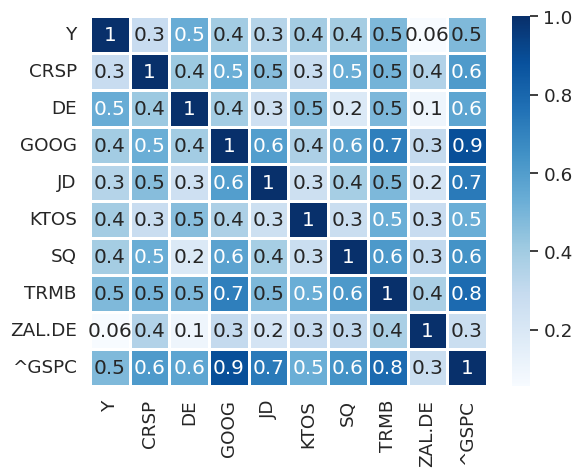

In [68]:
#Correlation Matrix (finding similar control groups)
sns.set(font_scale = 1.2)
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'Blues',
            linewidth = 1)

In [ ]:
#There is not a good corellation between Y and ZAL.DE

#Causal Impact

In [69]:
df_final = df.drop(columns = ["ZAL.DE"])
df_final.head(1)

,Y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,^GSPC
Date,,,,,,,,,
2020-09-01,11970.478516,93.419998,210.679596,83.0355,79.267685,19.700001,166.660004,53.41,3526.649902


In [71]:
#Pre and Post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


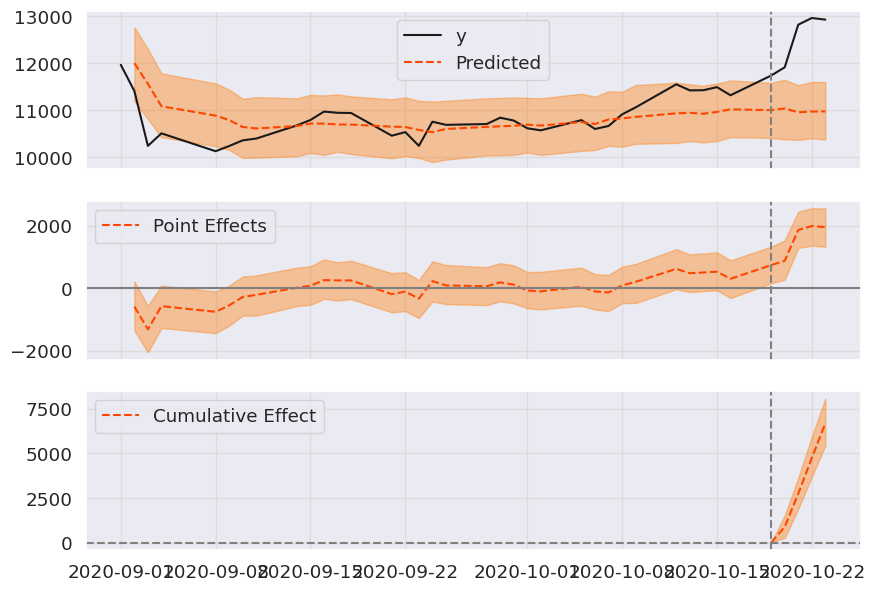

In [73]:
#Google Causal Impact
impactModel = CausalImpact(data = df_final,
                           pre_period = pre_period,
                           post_period = post_period)
impactModel.plot()

In [78]:
#In the second graph, the orange line is over 0 => positive impact (Immediate impact and after this stabilization) => Not a cummulate impact

In [79]:
print(impactModel.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         10988.95 (166.24)  43955.8 (664.94)
95% CI                    [10668.13, 11319.76][42672.51, 45279.03]

Absolute effect (s.d.)    1670.41 (166.24)   6681.65 (664.94)
95% CI                    [1339.61, 1991.24] [5358.43, 7964.95]

Relative effect (s.d.)    15.2% (1.51%)      15.2% (1.51%)
95% CI                    [12.19%, 18.12%]   [12.19%, 18.12%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [80]:
print(impactModel.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 10988.95.
The 95% interval of this counterfactual prediction is [10668.13, 11319.76].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1670.41 with a 95% interval of
[1339.61, 1991.24]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 43955.8. The 95% interval of this prediction is [42672.51, 45279.03].


The above results are given in terms of absolute numbers. In relative
t